In [1]:
from   ast import literal_eval
from   collections import Counter, defaultdict
from   geopy import distance
from   itertools import pairwise
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from   sklearn.linear_model import LinearRegression
from   scipy.stats import permutation_test
import seaborn as sns
import string
from   unidecode import unidecode

## Load derived data

In [2]:
data_dir = os.path.join('..', 'data')
derived_dir = os.path.join(data_dir, 'derived')

def string_to_list(x):
    lst = literal_eval(x.replace(', nan', "', ZZZZ'").replace('[nan, ', "'['").replace(', nan]', "']'"))
    return [i for i in lst if i != 'ZZZZ']

df = pd.read_csv(
    os.path.join(derived_dir, 'CONLIT_CharData_AP_4.csv.gz'), 
    index_col='book_id',
    converters={
        'gpe_places': string_to_list,
        'nongpe_places': string_to_list,
        'all_places': string_to_list,
        'gpe_sequences': string_to_list
    },
)
df = df.fillna('').drop(columns='X')

## GPE distances

In [3]:
gpe_counts = Counter()
for i in df.gpe_places:
    gpe_counts.update(i)
gpe_counts.most_common(20)

[('New York', 6683),
 ('London', 4367),
 ('Paris', 3673),
 ('America', 3477),
 ('Washington', 2412),
 ('England', 2087),
 ('California', 2064),
 ('Chicago', 2000),
 ('Boston', 1624),
 ('France', 1560),
 ('Rome', 1304),
 ('San Francisco', 1247),
 ('Los Angeles', 1247),
 ('Texas', 1047),
 ('New York City', 1046),
 ('Europe', 952),
 ('Berlin', 938),
 ('Manhattan', 908),
 ('Philadelphia', 862),
 ('Virginia', 854)]

### Geonames

In [4]:
gn_col_names = [
    'geonameid',
    'name',
    'asciiname',
    'alternatenames',
    'lat',
    'lon',
    'feature_class',
    'feature_code',
    'country_code',
    'cc2',
    'admin1_code',
    'admin2_code',
    'admin3_code',
    'admin4_code',
    'population',
    'elevation',
    'dem',
    'timezone',
    'mod_date'
]
gn = pd.read_csv(
    os.path.join(data_dir, 'geonames', 'allCountries.zip'), 
    sep='\t',
    names=gn_col_names,
    index_col=0,
    low_memory=False
)

gn_gpes = Counter()
for i in df.gpe_places:
    gn_gpes.update(i)
gn = gn.loc[gn.name.isin(gn_gpes)]

# retain only most-populous place per unique name
gn = gn.sort_values(by='population', ascending=False).drop_duplicates(subset=['name']).set_index('name')

In [5]:
# not used in current implementation
hierarchy = pd.read_csv(
    os.path.join(data_dir, 'geonames', 'hierarchy.zip'), 
    sep='\t',
    names=['parent', 'child', 'type']
)

feature_codes = pd.read_csv(
    os.path.join(data_dir, 'geonames', 'featureCodes_en.txt'),
    sep='\t',
    names=['feature_code', 'feature_name', 'feature_description']
)

### Wilkens geo data

In [6]:
# regularize data to wilkens geo format
punctuation_to_space = str.maketrans({key:' ' for key in string.punctuation})

def regularize_string(place_string):
    return(unidecode(' '.join(place_string.translate(punctuation_to_space).lower().split())))

wi = pd.read_csv(
    os.path.join('..', '..', 'toponyms', 'geo.tsv.gz'),
    sep='\t',
    low_memory=False,
)
wi = wi.loc[wi.lang=='en']
wi.set_index('text_string', inplace=True)

# hand review data
hand = pd.read_csv(
    os.path.join('..', '..', 'toponyms', 'us_handreview.tsv'),
    sep='\t',
    index_col='text_string'
)

# restore some items from C19 hand review
hand.loc[
    [
        'hollywood', 
        'dallas', 
        'florence', 
        'kingston',
        'berkeley', 
        'queens', 
        'phoenix', 
        'woodstock', 
        'surrey',
        'orlando'
    ], 
    'ignore'
] = 0

# improve alises
hand.loc['kingston', 'alias_to'] = 'kingston jamaica'

# drop ignored places
wi = wi.drop(hand.loc[hand.ignore==1].index, errors='ignore')

# alias places
for original_place, alias_to in hand.loc[(~hand.alias_to.isna()) & (hand.ignore==0) & (hand.alias_to.isin(wi.index)), 'alias_to'].items():
    wi.loc[original_place] = wi.loc[alias_to]

# drop unused places
wi_gpes = Counter()
for sequence in df.gpe_sequences:
    wi_gpes.update([regularize_string(i) for i in sequence])
wi.drop(wi.loc[~wi.index.isin(wi_gpes)].index, inplace=True, errors='ignore')

### Sequence distances

For each volume sequence, look up each place, get lat/lon, calculate distance from previous place, sum over sequential path.

If `source='wilkens'`, also perform fancier location aliasing, ignore known-bad places, and zero out sequence steps that move between admin levels within the same admin entity (e.g., `Boston -> United States` or `UK -> England`)

In [7]:
def get_lat_lon(place_string, geo_data, extended=False):
    '''Assumes lookup string has been regularized if necessary'''
    try:
        if extended:
            return(geo_data.loc[place_string, ['lat', 'lon', 'country_short', 'admin_1_std', 'location_type']])
        else:
            return(geo_data.loc[place_string, ['lat', 'lon']])
    except ValueError:
        return(None)

continents = { # not used in current implementation
    'africa',
    'antarctica',
    'asia',
    'australia',
    'europe',
    'north america',
    'south america'
}

def sequence_distance(sequence, source='geonames'):
    # set data, regularize strings, and remove unknown locations
    if source=='geonames':
        geo_data = gn
        seq = [i for i in sequence if i in geo_data.index]
    if source=='wilkens':
        geo_data = wi
        seq = [regularize_string(i) for i in sequence if regularize_string(i) in geo_data.index]
    total_distance = 0.0
    for location1, location2 in pairwise(seq):
        #print(location1, location2)
        if location1 in distances and location2 in distances[location1]:
            total_distance += distances[location1][location2]
        else:
            if source=='wilkens':
                loc1 = get_lat_lon(location1, geo_data, extended=True)
                loc2 = get_lat_lon(location2, geo_data, extended=True)
                if loc1 is None or loc2 is None: pass # should never happen, but check
                # eliminate place -> higher-order place in same admin area
                if (loc1.location_type=='country' or loc2.location_type=='country') and \
                   (loc2.country_short==loc1.country_short): pass
                elif (loc1.location_type=='administrative_area_level_1' or \
                      loc2.location_type=='administrative_area_level_1') and \
                     (loc2.country_short==loc1.country_short and \
                      loc2.admin_1_std==loc1.admin_1_std): pass
                else:
                    loc1 = loc1[['lat', 'lon']]
                    loc2 = loc2[['lat', 'lon']]   
                    dist = distance.distance(loc1, loc2).miles
                    total_distance += dist
                    distances[location1][location2] = dist
                    distances[location2][location1] = dist
            else:
                loc1 = get_lat_lon(location1, geo_data)
                loc2 = get_lat_lon(location2, geo_data)
                if loc1 is None or loc2 is None: pass # should never happen, but ...
                else: #compute dist and add to distances
                    dist = distance.distance(loc1, loc2).miles
                    total_distance += dist
                    distances[location1][location2] = dist
                    distances[location2][location1] = dist
    return(total_distance)

R^2 Sandeep/Wilkens naive v. Geoname naives: 0.893
CPU times: user 18.4 s, sys: 64.3 ms, total: 18.5 s
Wall time: 18.6 s


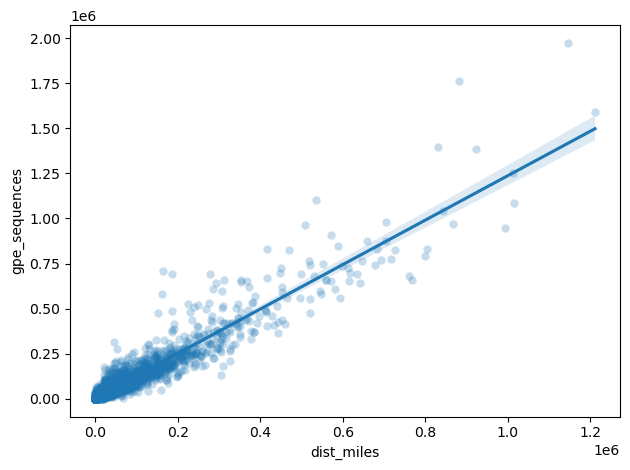

In [8]:
%%time
distances = defaultdict(lambda: defaultdict(float))
gn_distances = df['gpe_sequences'].apply(sequence_distance, source='geonames')

clf = LinearRegression().fit(X=df[['dist_miles']], y=gn_distances)
print(f"R^2 Sandeep/Wilkens naive v. Geoname naives: {clf.score(X=df[['dist_miles']], y=gn_distances):.3f}")

sns.regplot(x=df.dist_miles, y=gn_distances, scatter_kws={'alpha':0.25, 'linewidth':0})
plt.tight_layout()

In [9]:
%%time
distances = defaultdict(lambda: defaultdict(float))
wi_distances = df['gpe_sequences'].apply(sequence_distance, source='wilkens')

clf = LinearRegression().fit(X=df[['dist_miles']], y=wi_distances)
print(f"R^2 Wilkens naive v. Wilkens fancy: {clf.score(X=df[['dist_miles']], y=wi_distances):.3f}")

#sns.regplot(x=df.dist_miles, y=wi_distances, scatter_kws={'alpha':0.25, 'linewidth':0})
#plt.tight_layout()

R^2 Wilkens naive v. Wilkens fancy: 0.986
CPU times: user 31 s, sys: 57.1 ms, total: 31 s
Wall time: 31.1 s


In [10]:
X_wi = pd.DataFrame(wi_distances)
clf = LinearRegression().fit(X=X_wi, y=gn_distances)
print(f"R^2 Wilkens fancy v. Geonames naive: {clf.score(X=X_wi, y=gn_distances):.3f}")

R^2 Wilkens fancy v. Geonames naive: 0.865


### Save new distances to CSV

In [11]:
df['dist_miles'] = wi_distances
df.to_csv(os.path.join(derived_dir, 'CONLIT_CharData_AP_MW_4.csv.gz'))

In [14]:
df['dist_miles'].to_csv(os.path.join(derived_dir, 'CONLIT_CharData_dist_miles.csv.gz'))

## Feature differences by facet

In [12]:
facet_by = ['inf_gender', 'Category', 'Genre']

cols_to_test = [
    'char_count', 
    'num_gpe_places', 
    'num_nongpe_places',
    'num_all_places', 
    'dist_miles', 
    'Tokens', 
    'num_gpe_places_norm',
    'num_nongpe_places_norm', 
    'num_gpe_places_norm_byCharacter',
    'num_nongpe_places_norm_byCharacter', 
    'char_count_norm',
    'nongpe_places_total', 
    'gpe_places_total',
    'ttr_nongpe', 
    'ttr_gpe', 
    'avg_Distance_GPE', 
    'non_gpe_ratio',
    'avg_Distance_GPE_Tokens', 
    'deixis_count_perplace',
    'semantic_dist_mean', 
    'semantic_dist_total', 
    'dist_miles_allChars',
    'dist_miles_allChars_norm_Tokens',
    'num_gpe_places_allChars_norm_Tokens'
]

def significance_label(pvalue, levels=[0.05, 0.01, 0.001]):
    if pvalue < levels[2]:
        return '***'
    elif pvalue < levels[1]:
        return '**'
    elif pvalue < levels[0]:
        return '*'
    else: 
        return ''

def diff_means(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

def compare_facets(df, facets, cols, statistic=diff_means):
    '''Compare statistic in cols of df via permutation. Display results, return nothing.'''
    for facet in facets:
        print(f"\n==============\nFacet: {facet}\n==============")
        df = df.dropna(subset=[facet])
        for level in df[facet].unique():
            data = (df.loc[df[facet]==level, cols], df.loc[~(df[facet]==level), cols])
            level_mean = np.mean(data[0], axis=0)
            other_mean = np.mean(data[1], axis=0)
            output = pd.DataFrame(level_mean, columns=[level]).join(pd.DataFrame(other_mean, columns=['others']))
            res = permutation_test(data, statistic)
            output['diff'] = res.statistic
            output['p'] = res.pvalue
            output['sig'] = output['p'].apply(significance_label)
            display(output)

In [13]:
compare_facets(df, facet_by, cols_to_test, diff_means)


Facet: inf_gender


,she/her,others,diff,p,sig
char_count,3752.279775,3836.972103,-84.692328,0.4388,
num_gpe_places,16.356180,21.775215,-5.419035,0.0002,***
num_nongpe_places,122.757303,123.050429,-0.293126,0.9128,
num_all_places,138.620225,144.250536,-5.630312,0.1158,
dist_miles,51501.447552,72607.991719,-21106.544167,0.0002,***
Tokens,119516.989888,131766.641631,-12249.651743,0.0002,***
num_gpe_places_norm,0.000141,0.000170,-0.000029,0.0002,***
num_nongpe_places_norm,0.001127,0.001046,0.000080,0.0014,**
num_gpe_places_norm_byCharacter,0.005224,0.009565,-0.004342,0.0002,***
num_nongpe_places_norm_byCharacter,0.036178,0.037655,-0.001477,0.0356,*


,he/him/his,others,diff,p,sig
char_count,4012.726801,3463.752699,5.489741e+02,0.0002,***
num_gpe_places,22.025360,16.616290,5.409070e+00,0.0002,***
num_nongpe_places,127.342939,115.485770,1.185717e+01,0.0002,***
num_all_places,148.785591,131.611384,1.717421e+01,0.0002,***
dist_miles,73533.779439,52597.132049,2.093665e+04,0.0002,***
Tokens,133472.337752,118163.527969,1.530881e+04,0.0002,***
num_gpe_places_norm,0.000169,0.000146,2.304138e-05,0.0002,***
num_nongpe_places_norm,0.001073,0.001072,8.203127e-07,0.9730,
num_gpe_places_norm_byCharacter,0.008396,0.007764,6.324582e-04,0.1758,
num_nongpe_places_norm_byCharacter,0.036880,0.037683,-8.029464e-04,0.2542,


,they/them/their,others,diff,p,sig
char_count,1490.612903,3918.938783,-2428.325880,0.0002,***
num_gpe_places,18.870968,20.078327,-1.207359,0.5596,
num_nongpe_places,66.516129,125.616730,-59.100601,0.0002,***
num_all_places,84.903226,145.143346,-60.240120,0.0002,***
dist_miles,61883.407727,65971.118755,-4087.711028,0.6978,
Tokens,109909.790323,128651.835361,-18742.045039,0.0008,***
num_gpe_places_norm,0.000183,0.000160,0.000024,0.0824,
num_nongpe_places_norm,0.000695,0.001090,-0.000396,0.0002,***
num_gpe_places_norm_byCharacter,0.025981,0.007322,0.018659,0.0002,***
num_nongpe_places_norm_byCharacter,0.048523,0.036643,0.011881,0.0002,***


,,others,diff,p,sig
char_count,1039.800000,3814.640233,-2774.840233,0.0014,**
num_gpe_places,7.000000,20.047654,-13.047654,0.0470,*
num_nongpe_places,35.600000,123.114587,-87.514587,0.0006,***
num_all_places,42.400000,142.612950,-100.212950,0.0002,***
dist_miles,17329.335781,65875.204876,-48545.869095,0.1486,
Tokens,81940.000000,127891.393598,-45951.393598,0.0408,*
num_gpe_places_norm,0.000125,0.000161,-0.000036,0.6506,
num_nongpe_places_norm,0.000645,0.001073,-0.000428,0.0916,
num_gpe_places_norm_byCharacter,0.008103,0.008162,-0.000059,0.7796,
num_nongpe_places_norm_byCharacter,0.036873,0.037178,-0.000305,0.9016,



Facet: Category


,FIC,others,diff,p,sig
char_count,4201.894519,2884.367073,1317.527446,0.0002,***
num_gpe_places,13.344881,35.776829,-22.431948,0.0002,***
num_nongpe_places,123.875388,120.786585,3.088802,0.3204,
num_all_places,136.805584,155.698780,-18.893196,0.0002,***
dist_miles,38021.839807,131272.374020,-93250.534213,0.0002,***
Tokens,121620.681489,142400.906098,-20780.224608,0.0002,***
num_gpe_places_norm,0.000117,0.000263,-0.000145,0.0002,***
num_nongpe_places_norm,0.001116,0.000970,0.000146,0.0002,***
num_gpe_places_norm_byCharacter,0.003816,0.018413,-0.014597,0.0002,***
num_nongpe_places_norm_byCharacter,0.033306,0.046310,-0.013004,0.0002,***


,NON,others,diff,p,sig
char_count,2884.367073,4201.894519,-1317.527446,0.0002,***
num_gpe_places,35.776829,13.344881,22.431948,0.0002,***
num_nongpe_places,120.786585,123.875388,-3.088802,0.3084,
num_all_places,155.698780,136.805584,18.893196,0.0002,***
dist_miles,131272.374020,38021.839807,93250.534213,0.0002,***
Tokens,142400.906098,121620.681489,20780.224608,0.0002,***
num_gpe_places_norm,0.000263,0.000117,0.000145,0.0002,***
num_nongpe_places_norm,0.000970,0.001116,-0.000146,0.0002,***
num_gpe_places_norm_byCharacter,0.018413,0.003816,0.014597,0.0002,***
num_nongpe_places_norm_byCharacter,0.046310,0.033306,0.013004,0.0002,***



Facet: Genre


,YA,others,diff,p,sig
char_count,5664.129944,3682.225068,1981.904876,0.0002,***
num_gpe_places,11.519774,20.608071,-9.088297,0.0002,***
num_nongpe_places,130.824859,122.415211,8.409647,0.1548,
num_all_places,141.903955,142.467210,-0.563255,0.9422,
dist_miles,28737.615271,68331.791611,-39594.176340,0.0002,***
Tokens,106057.067797,129301.916958,-23244.849161,0.0002,***
num_gpe_places_norm,0.000113,0.000164,-0.000050,0.0002,***
num_nongpe_places_norm,0.001257,0.001060,0.000197,0.0004,***
num_gpe_places_norm_byCharacter,0.002359,0.008561,-0.006202,0.0002,***
num_nongpe_places_norm_byCharacter,0.024377,0.038057,-0.013679,0.0002,***


,SF,others,diff,p,sig
char_count,3836.775785,3807.208218,29.567567,0.8566,
num_gpe_places,12.713004,20.668115,-7.955111,0.0002,***
num_nongpe_places,116.269058,123.544844,-7.275786,0.1630,
num_all_places,128.367713,143.670091,-15.302378,0.0138,*
dist_miles,31071.725037,68845.748795,-37774.023758,0.0002,***
Tokens,144342.304933,126351.168313,17991.136620,0.0006,***
num_gpe_places_norm,0.000098,0.000166,-0.000069,0.0002,***
num_nongpe_places_norm,0.000898,0.001088,-0.000189,0.0002,***
num_gpe_places_norm_byCharacter,0.003760,0.008550,-0.004790,0.0002,***
num_nongpe_places_norm_byCharacter,0.031872,0.037645,-0.005773,0.0002,***


,BS,others,diff,p,sig
char_count,4729.730924,3718.140519,1011.590405,0.0002,***
num_gpe_places,17.694779,20.255489,-2.560710,0.0650,
num_nongpe_places,143.425703,120.920958,22.504745,0.0002,***
num_all_places,160.618474,140.623154,19.995320,0.0012,**
dist_miles,49632.755582,67392.825846,-17760.070264,0.0054,**
Tokens,155119.140562,125093.203593,30025.936969,0.0002,***
num_gpe_places_norm,0.000126,0.000164,-0.000038,0.0002,***
num_nongpe_places_norm,0.001017,0.001078,-0.000061,0.1276,
num_gpe_places_norm_byCharacter,0.004617,0.008515,-0.003898,0.0002,***
num_nongpe_places_norm_byCharacter,0.034983,0.037396,-0.002412,0.0358,*


,NYT,others,diff,p,sig
char_count,3716.871122,3826.242398,-109.371277,0.4466,
num_gpe_places,16.365155,20.680514,-4.315359,0.0002,***
num_nongpe_places,129.603819,121.762741,7.841078,0.0498,*
num_all_places,145.572792,141.867238,3.705555,0.4462,
dist_miles,52078.681875,68246.945259,-16168.263384,0.0026,**
Tokens,118115.806683,129547.159743,-11431.353060,0.0012,**
num_gpe_places_norm,0.000151,0.000162,-0.000012,0.1126,
num_nongpe_places_norm,0.001196,0.001050,0.000146,0.0002,***
num_gpe_places_norm_byCharacter,0.004908,0.008746,-0.003838,0.0002,***
num_nongpe_places_norm_byCharacter,0.037977,0.037034,0.000943,0.3278,


,MY,others,diff,p,sig
char_count,4099.149573,3782.715873,316.433700,0.0890,
num_gpe_places,13.286325,20.649603,-7.363278,0.0002,***
num_nongpe_places,132.316239,122.086508,10.229731,0.0510,
num_all_places,145.226496,142.171429,3.055067,0.6040,
dist_miles,33531.764764,68782.203147,-35250.438383,0.0002,***
Tokens,124630.961538,128102.974603,-3472.013065,0.4484,
num_gpe_places_norm,0.000109,0.000165,-0.000056,0.0002,***
num_nongpe_places_norm,0.001113,0.001069,0.000045,0.2782,
num_gpe_places_norm_byCharacter,0.003733,0.008574,-0.004840,0.0002,***
num_nongpe_places_norm_byCharacter,0.034180,0.037456,-0.003276,0.0068,**


,ROM,others,diff,p,sig
char_count,5970.480769,3633.065593,2337.415176,0.0002,***
num_gpe_places,7.625000,21.036921,-13.411921,0.0002,***
num_nongpe_places,108.990385,124.096622,-15.106238,0.0028,**
num_all_places,116.403846,144.557345,-28.153499,0.0002,***
dist_miles,20950.401077,69450.079128,-48499.678051,0.0002,***
Tokens,103573.639423,129787.833464,-26214.194041,0.0002,***
num_gpe_places_norm,0.000075,0.000168,-0.000093,0.0002,***
num_nongpe_places_norm,0.001099,0.001070,0.000029,0.5294,
num_gpe_places_norm_byCharacter,0.001397,0.008715,-0.007318,0.0002,***
num_nongpe_places_norm_byCharacter,0.019871,0.038591,-0.018720,0.0002,***


,HIST,others,diff,p,sig
char_count,987.385366,4036.575520,-3049.190154,0.0002,***
num_gpe_places,20.839024,19.958415,0.880609,0.5766,
num_nongpe_places,48.063415,128.978815,-80.915401,0.0002,***
num_all_places,68.556098,148.372303,-79.816205,0.0002,***
dist_miles,59830.022183,66266.155487,-6436.133304,0.4076,
Tokens,148252.897561,126163.710082,22089.187479,0.0002,***
num_gpe_places_norm,0.000152,0.000161,-0.000009,0.3780,
num_nongpe_places_norm,0.000349,0.001131,-0.000782,0.0002,***
num_gpe_places_norm_byCharacter,0.030387,0.006375,0.024012,0.0002,***
num_nongpe_places_norm_byCharacter,0.051873,0.035996,0.015878,0.0002,***


,PW,others,diff,p,sig
char_count,3166.751938,3876.050881,-709.298943,0.0002,***
num_gpe_places,14.771318,20.566907,-5.795589,0.0002,***
num_nongpe_places,121.062016,123.151442,-2.089427,0.6830,
num_all_places,135.387597,143.159054,-7.771458,0.1760,
dist_miles,48967.555274,67525.623247,-18558.067973,0.0030,**
Tokens,121945.096899,128413.984776,-6468.887876,0.1364,
num_gpe_places_norm,0.000135,0.000163,-0.000029,0.0010,**
num_nongpe_places_norm,0.001106,0.001069,0.000037,0.3500,
num_gpe_places_norm_byCharacter,0.005246,0.008464,-0.003217,0.0002,***
num_nongpe_places_norm_byCharacter,0.042435,0.036634,0.005801,0.0002,***


,MIX,others,diff,p,sig
char_count,1859.585492,3956.557985,-2096.972493,0.0002,***
num_gpe_places,25.191710,19.634518,5.557192,0.0012,**
num_nongpe_places,83.694301,125.914487,-42.220186,0.0002,***
num_all_places,108.336788,145.000390,-36.663603,0.0002,***
dist_miles,97639.696215,63386.615976,34253.080239,0.0004,***
Tokens,125705.056995,127966.444748,-2261.387753,0.6728,
num_gpe_places_norm,0.000202,0.000158,0.000045,0.0002,***
num_nongpe_places_norm,0.000739,0.001098,-0.000359,0.0002,***
num_gpe_places_norm_byCharacter,0.018464,0.007386,0.011078,0.0002,***
num_nongpe_places_norm_byCharacter,0.046090,0.036506,0.009584,0.0002,***


,MEM,others,diff,p,sig
char_count,4260.253275,3768.731485,491.521790,0.0114,*
num_gpe_places,37.877729,18.404752,19.472977,0.0002,***
num_nongpe_places,170.908297,118.606733,52.301564,0.0002,***
num_all_places,207.737991,136.508119,71.229872,0.0002,***
dist_miles,147811.848938,58347.988704,89463.860234,0.0002,***
Tokens,105611.161572,129821.063366,-24209.901794,0.0002,***
num_gpe_places_norm,0.000355,0.000143,0.000212,0.0002,***
num_nongpe_places_norm,0.001666,0.001019,0.000647,0.0002,***
num_gpe_places_norm_byCharacter,0.009739,0.008019,0.001720,0.0472,*
num_nongpe_places_norm_byCharacter,0.041595,0.036777,0.004819,0.0002,***


,MID,others,diff,p,sig
char_count,3103.355422,3854.902628,-751.547206,0.0002,***
num_gpe_places,7.024096,20.857805,-13.833709,0.0002,***
num_nongpe_places,94.024096,124.811437,-30.787341,0.0002,***
num_all_places,100.753012,145.104328,-44.351316,0.0002,***
dist_miles,15068.771786,69040.250683,-53971.478897,0.0002,***
Tokens,84156.487952,130607.868624,-46451.380673,0.0002,***
num_gpe_places_norm,0.000089,0.000165,-0.000076,0.0002,***
num_nongpe_places_norm,0.001243,0.001062,0.000181,0.0002,***
num_gpe_places_norm_byCharacter,0.002412,0.008531,-0.006119,0.0002,***
num_nongpe_places_norm_byCharacter,0.031853,0.037519,-0.005666,0.0002,***


,BIO,others,diff,p,sig
char_count,4291.549223,3773.282312,518.266911,0.0136,*
num_gpe_places,59.735751,17.031238,42.704513,0.0002,***
num_nongpe_places,175.652850,118.984381,56.668469,0.0002,***
num_all_places,233.875648,135.539633,98.336015,0.0002,***
dist_miles,221164.856853,54077.613242,167087.243612,0.0002,***
Tokens,196532.989637,122628.767669,73904.221968,0.0002,***
num_gpe_places_norm,0.000331,0.000148,0.000184,0.0002,***
num_nongpe_places_norm,0.001036,0.001075,-0.000039,0.3984,
num_gpe_places_norm_byCharacter,0.015934,0.007577,0.008357,0.0002,***
num_nongpe_places_norm_byCharacter,0.046214,0.036497,0.009717,0.0002,***
